In [ ]:
import numpy as np
from scipy.stats import norm, expon
from scipy.special import erfc

class EMGMixtureEM:
    def __init__(self, n_components, max_iter=100, tol=1e-6):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.weights_ = None
        self.means_ = None
        self.stds_ = None
        self.lambdas_ = None

    def _emg_pdf(self, x, mu, sigma, lamb):
        """Compute the PDF of the Exponentially Modified Gaussian."""
        if sigma <= 0 or lamb <= 0:
            return np.zeros_like(x)

        exp_term = np.exp((lamb / 2) * (2 * mu + lamb * sigma**2 - 2 * x))
        erfc_term = erfc((mu + lamb * sigma**2 - x) / (np.sqrt(2) * sigma))
        return (lamb / 2) * exp_term * erfc_term

    def _initialize_parameters(self, X):
        """Random initialization of weights, means, stds, and lambdas."""
        N = X.shape[0]
        self.weights_ = np.ones(self.n_components) / self.n_components
        self.means_ = np.random.choice(X, self.n_components)
        self.stds_ = np.random.random(self.n_components) * np.std(X)
        self.lambdas_ = np.random.random(self.n_components) * 0.1

    def fit(self, X):
        """Fit the EMG mixture model to the data."""
        N = X.shape[0]
        self._initialize_parameters(X)

        log_likelihoods = []

        for iteration in range(self.max_iter):
            # E-Step
            responsibilities = np.zeros((N, self.n_components))
            for k in range(self.n_components):
                responsibilities[:, k] = (
                    self.weights_[k] * self._emg_pdf(X, self.means_[k], self.stds_[k], self.lambdas_[k])
                )
            
            total_responsibilities = np.sum(responsibilities, axis=1, keepdims=True)
            responsibilities /= total_responsibilities

            # M-Step
            Nk = np.sum(responsibilities, axis=0)  # Effective number of points for each component

            self.weights_ = Nk / N
            self.means_ = np.sum(responsibilities * X[:, np.newaxis], axis=0) / Nk
            self.stds_ = np.sqrt(np.sum(responsibilities * (X[:, np.newaxis] - self.means_)**2, axis=0) / Nk)

            def optimize_lambda(X, r, mu, sigma, lambda_):
                """Optimize lambda for a single component."""

                def objective(lamb):
                    tau = 0.8
                    pdf_vals = self._emg_pdf(X, mu, sigma, lamb)
                    return -(1 - tau) * np.sum(r * np.log(pdf_vals)) + tau * lambda_

                from scipy.optimize import minimize_scalar
                res = minimize_scalar(objective, bounds=(1e-5, 10), method='bounded')
                return res.x

            self.lambdas_ = np.array([
                optimize_lambda(X, responsibilities[:, k], self.means_[k], self.stds_[k], self.lambdas_[k])
                for k in range(self.n_components)
            ])

            # Compute log-likelihood
            log_likelihood = np.sum(np.log(total_responsibilities))
            log_likelihoods.append(log_likelihood)

            # Check for convergence
            if len(log_likelihoods) > 1 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < self.tol:
                break

        return self

    def predict_proba(self, X):
        """Predict the responsibilities (posterior probabilities)."""
        N = X.shape[0]
        responsibilities = np.zeros((N, self.n_components))
        for k in range(self.n_components):
            responsibilities[:, k] = (
                self.weights_[k] * self._emg_pdf(X, self.means_[k], self.stds_[k], self.lambdas_[k])
            )
        total_responsibilities = np.sum(responsibilities, axis=1, keepdims=True)
        return responsibilities / total_responsibilities

    def sample(self, n_samples):
        """Generate samples from the fitted mixture model."""
        samples = []
        component_choices = np.random.choice(
            self.n_components, size=n_samples, p=self.weights_
        )
        for k in range(self.n_components):
            n_k = np.sum(component_choices == k)
            if n_k > 0:
                gaussian_samples = np.random.normal(self.means_[k], self.stds_[k], size=n_k)
                exponential_samples = np.random.exponential(1 / self.lambdas_[k], size=n_k)
                samples.append(gaussian_samples + exponential_samples)
        return np.concatenate(samples)

# Example Usage
np.random.seed(42)
X = np.concatenate([
    np.random.normal(2, 0.5, 500) + np.random.exponential(0.0005, 500),
    np.random.normal(6, 1, 300) + np.random.exponential(0.5, 300),
    np.random.normal(8, 0.15, 500)
])

model = EMGMixtureEM(n_components=3)
model.fit(X)

print("Means:", model.means_)
print("Stds:", model.stds_)
print("Lambdas:", model.lambdas_)


/tmp/ipykernel_11741/3753645658.py:64: RuntimeWarning: divide by zero encountered in log
  return -(1 - tau) * np.sum(r * np.log(pdf_vals)) + tau * lambda_
/home/racaillou/miniconda3/envs/fmr/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2288: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/home/racaillou/miniconda3/envs/fmr/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2289: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/tmp/ipykernel_11741/3753645658.py:64: RuntimeWarning: invalid value encountered in multiply
  return -(1 - tau) * np.sum(r * np.log(pdf_vals)) + tau * lambda_


Means: [6.86430092 8.05735332 2.00978611]
Stds: [1.06823806 0.19822821 0.49749082]
Lambdas: [9.9999959  3.81966629 9.99999304]


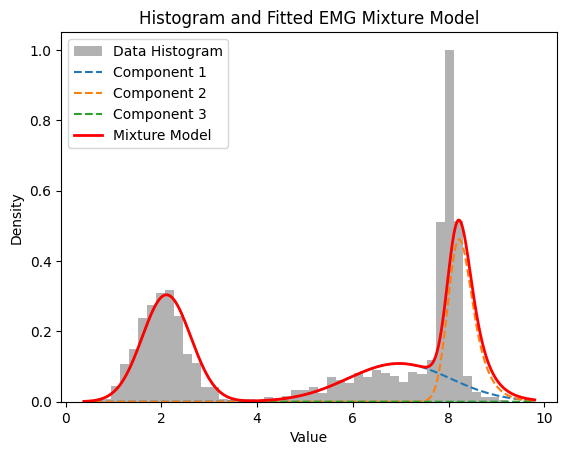

In [34]:
import matplotlib.pyplot as plt

def plot_emg_mixture(model, X, bins=50):
    """Plot the histogram of data and the fitted EMG mixture model."""
    # Histogram of data
    plt.hist(X, bins=bins, density=True, alpha=0.6, color='gray', label='Data Histogram')
    
    # Generate theoretical distribution
    x_vals = np.linspace(min(X), max(X), 1000)
    y_vals = np.zeros_like(x_vals)
    
    for k in range(model.n_components):
        component_pdf = (
            model.weights_[k]
            * model._emg_pdf(x_vals, model.means_[k], model.stds_[k], model.lambdas_[k])
        )
        y_vals += component_pdf
        # Plot each component
        plt.plot(x_vals, component_pdf, label=f'Component {k+1}', linestyle='dashed')
    
    # Plot the overall mixture
    plt.plot(x_vals, y_vals, label='Mixture Model', color='red', linewidth=2)
    
    # Labels and legend
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Histogram and Fitted EMG Mixture Model')
    plt.legend()
    plt.show()

# Call the plotting function
plot_emg_mixture(model, X)
